# GPM: A graph convolutional network based reinforcement learning framework for portfolio management

In this document, we will make use of a graph neural network architecture called GPM, introduced in the following paper:

- Si Shi, Jianjun Li, Guohui Li, Peng Pan, Qi Chen & Qing Sun. (2022). GPM: A graph convolutional network based reinforcement learning framework for portfolio management. https://doi.org/10.1016/j.neucom.2022.04.105.

### Note
If you're using the portfolio optimization environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
# install finrl library
#!sudo apt install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-cjpcxf5m
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-cjpcxf5m


  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit fb330fab0d6336c190f1173dcdc36c729e95352b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-frcs4hxn/elegantrl_03456b19e7a54d19816b6be51ca77e8c
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-frcs4hxn/elegantrl_03456b19e7a54d19816b6be51ca77e8c
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5a22ed2e88cb8389f03241ea72a3395fefc09bd5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached alpaca_trade_api-3.2.0-py3-none-any.whl.metadata (29 kB)
  Using cached ccxt-3.1.60-py2.py3-none-any.whl.metadata (108 kB)
  Using cached exchange_calendars-4.5.5-py3-no

In [2]:
# We also need to install quantstats, because the environment uses it to plot graphs
!pip install quantstats

In [3]:
# Hide matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [4]:
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [8]:
!pip install gymnasium gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827626 sha256=318817721522f7bd820a8bf9778e2503343a49f9d367020461cc0b29f9b9b468
  Stored in directory: /home/codespace/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym


In [4]:
import torch

import numpy as np
import pandas as pd

from torch_geometric.utils import k_hop_subgraph

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import GPM

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

We are going to use the same data used in the paper. The original data can be found in [Temporal_Relational_Stock_Ranking repository](https://github.com/fulifeng/Temporal_Relational_Stock_Ranking), but it's not in a FinRL friendly format. So, we're going to get the processed and FinRL-friendly data from [Temporal_Relational_Stock_Ranking_FinRL repository](https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL).

In [10]:
# download repository with data and extract tar.gz file with processed temporal data
!curl -L -O https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL/archive/refs/heads/main.zip
!unzip main.zip
!mv Temporal_Relational_Stock_Ranking_FinRL-main Temporal_Relational_Stock_Ranking_FinRL
!tar -xzvf Temporal_Relational_Stock_Ranking_FinRL/temporal_data/temporal_data_processed.tar.gz -C Temporal_Relational_Stock_Ranking_FinRL/temporal_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  146M    0  146M    0     0  9116k      0 --:--:--  0:00:16 --:--:-- 11.9M
Archive:  main.zip
b0a94b8166432fd6440899e8111aaef24f5cff62
   creating: Temporal_Relational_Stock_Ranking_FinRL-main/
 extracting: Temporal_Relational_Stock_Ranking_FinRL-main/.gitignore  
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/LICENSE  
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/README.md  
   creating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/
   creating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/edge_indexes/
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/edge_indexes/NASDAQ_sector_industry_edge

In [5]:
nasdaq_temporal = pd.read_csv("Temporal_Relational_Stock_Ranking_FinRL/temporal_data/NASDAQ_temporal_data.csv")
nasdaq_temporal

day      open      high       low     close    volume   tic
0           0  0.270533  0.269522  0.267237  0.263333  0.275333  AABA
1           0  0.238730  0.237522  0.239888  0.240502  0.248031  AAON
2           0  0.424556  0.424768  0.429769  0.442628  0.445018  AAPL
3           0  0.650667  0.648412  0.634492  0.631473  0.667839  AAWW
4           0  0.766565  0.761693  0.759330  0.750061  0.788157  AAXJ
...       ...       ...       ...       ...       ...       ...   ...
1277365  1244  0.909992  0.918809  0.912345  0.922698  0.913021  ZBRA
1277366  1244  0.660990  0.648907  0.636086  0.630816  0.665167  ZEUS
1277367  1244  0.981600  0.961674  0.926768  0.914257  0.984345  ZION
1277368  1244  0.980227  0.974903  0.960225  0.964956  0.997580   ZIV
1277369  1244  0.509179  0.500725  0.475543  0.459018  0.512077  ZUMZ

[1277370 rows x 7 columns]

In [6]:
nasdaq_edge_index = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_indexes/NASDAQ_sector_industry_edge_index.npy")
nasdaq_edge_index

array([[   0,   15,    0, ..., 1021, 1014, 1024],
       [  15,    0,   18, ..., 1011, 1024, 1014]])

In [7]:
nasdaq_edge_type = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_types/NASDAQ_sector_industry_edge_type.npy")
nasdaq_edge_type

array([ 0,  0,  0, ...,  1, 26, 26])

### Simplify Data

The graph loaded is too big, causing the training process to be extremely slow. So we are going to remove some of the stocks in the graph structure so that only stocks from 2 hops of the ones in our portfolio are considered.

In [8]:
list_of_stocks = nasdaq_temporal["tic"].unique().tolist()
tics_in_portfolio = ["AAPL", "CMCSA", "CSCO", "FB", "HBAN", "INTC", "MSFT", "MU", "NVDA", "QQQ", "XIV"]

portfolio_nodes = []
for tic in tics_in_portfolio:
    portfolio_nodes.append(list_of_stocks.index(tic))
portfolio_nodes

[2, 185, 215, 310, 395, 464, 596, 603, 637, 768, 1014]

In [9]:
np.shape(list_of_stocks)

(1026,)

In [20]:
nodes_kept, new_edge_index, nodes_to_select, edge_mask = k_hop_subgraph(
    torch.LongTensor(portfolio_nodes),
    2,
    torch.from_numpy(nasdaq_edge_index),
    relabel_nodes=True,
)

In [11]:
# reduce temporal data
nodes_kept = nodes_kept.tolist()
nasdaq_temporal["tic_id"], _ = pd.factorize(nasdaq_temporal["tic"], sort=True)
nasdaq_temporal = nasdaq_temporal[nasdaq_temporal["tic_id"].isin(nodes_kept)]
nasdaq_temporal = nasdaq_temporal.drop(columns="tic_id")
nasdaq_temporal

day      open      high       low     close    volume   tic
2           0  0.424556  0.424768  0.429769  0.442628  0.445018  AAPL
4           0  0.766565  0.761693  0.759330  0.750061  0.788157  AAXJ
7           0  0.244700  0.244212  0.238217  0.231041  0.251322  ABCB
8           0  0.689403  0.698864  0.695715  0.675068  0.708124  ABCO
13          0  0.566419  0.564621  0.563147  0.560503  0.579132  ACIW
...       ...       ...       ...       ...       ...       ...   ...
1277358  1244  0.923544  0.922537  0.896003  0.888519  0.966042   XIV
1277359  1244  0.919490  0.931946  0.950966  0.960872  0.920000  XLNX
1277361  1244  0.736906  0.747264  0.744030  0.745198  0.743781  YNDX
1277367  1244  0.981600  0.961674  0.926768  0.914257  0.984345  ZION
1277368  1244  0.980227  0.974903  0.960225  0.964956  0.997580   ZIV

[517920 rows x 7 columns]

In [12]:
# reduce edge type
new_edge_type = torch.from_numpy(nasdaq_edge_type)[edge_mask]
_, new_edge_type = torch.unique(new_edge_type, return_inverse=True)
new_edge_type

tensor([0, 0, 0,  ..., 2, 6, 6])

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [13]:
df_portfolio = nasdaq_temporal[["day", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[df_portfolio["day"] < 979]
df_portfolio_test = df_portfolio[df_portfolio["day"] >= 979]

time_window = 60

environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=time_window,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=time_window,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EI3 architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [14]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": GPM,
}

# here, we can set GPM's parameters
policy_kwargs = {
    "edge_index": new_edge_index,
    "edge_type": new_edge_type,
    "nodes_to_select": nodes_to_select,
    "softmax_temperature":4000,
    "device":device,
    # "k_short":6,
    # "k_medium":25,
    "time_window":time_window,
}

model = DRLAgent(environment_train).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

We will train only a few episodes because training takes a considerable time.

In [16]:
import json

In [19]:
def create_env(time_window, df_portfolio_train, df_portfolio_test, tics_in_portfolio):
    environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=time_window,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

    environment_test = PortfolioOptimizationEnv(
            df_portfolio_test,
            initial_amount=100000,
            comission_fee_pct=0.0025,
            time_window=time_window,
            features=["close", "high", "low"],
            time_column="day",
            normalize_df=None, # dataframe is already normalized
            tics_in_portfolio=tics_in_portfolio
        )
    return environment_train, environment_test

def create_model(time_window, soft_temp, GPM, new_edge_index, new_edge_type, node_to_select, device, envvironment_train):
    # set PolicyGradient parameters
    model_kwargs = {
        "lr": 0.01,
        "policy": GPM,
    }

    # here, we can set GPM's parameters
    policy_kwargs = {
        "edge_index": new_edge_index,
        "edge_type": new_edge_type,
        "nodes_to_select": nodes_to_select,
        "softmax_temperature":soft_temp,
        "device":device,
        # "k_short":6,
        # "k_medium":25,
        "time_window":time_window,
    }

    model = DRLAgent(environment_train).get_model("pg", device, model_kwargs, policy_kwargs)
    return model

def test_model(tw, st, device, environment_train, environment_test, model, new_edge_index, new_edge_type, node_to_select):
    GPM_results = {
        "train": environment_train._asset_memory["final"],
        "test": {},
    }

    # instantiate an architecture with the same arguments used in training
    # and load with load_state_dict.
    policy = GPM(new_edge_index, new_edge_type, nodes_to_select,
        softmax_temperature=st,
        device=device,
        # k_short=6,
        # k_medium=25,
        time_window=tw)
    policy.load_state_dict(torch.load("policy_GPM.pt", map_location=torch.device('cpu')))

    # testing
    DRLAgent.DRL_validation(model, environment_test, policy=policy)
    GPM_results["test"] = environment_test._asset_memory["final"]
    file_name = 'data_tw_'+str{tw}+'_st_'+str{st}+'.json'
    with open(file_name, 'w') as json_file:
        json.dump(GPM_results, json_file, indent=4)
    

SyntaxError: invalid syntax (233950238.py, line 66)

In [25]:
time_window = [50, 60, 70, 80, 90, 100]
soft_temp = [3000, 3500, 4000, 4500, 5000, 5500, 6000]

for tw in time_window:
    for st in soft_temp:
        if tw==50 and st==3000:
            pass
        else:
            environment_train, environment_test = create_env(tw,
                                                            df_portfolio_train, df_portfolio_test, tics_in_portfolio)
            model = create_model(tw, st, GPM, new_edge_index, 
                                new_edge_type, node_to_select, device, environment_train)

            DRLAgent.train_model(model, episodes=16)
            torch.save(model.train_policy.state_dict(), "policy_GPM_tw_"+str{tw}+"_st_"+str{st}+".pt")
            test_model(tw, st, device, environment_train, environment_test, model, new_edge_index, new_edge_type, node_to_select)



  0%|          | 0/16 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 195800.8125
Final accumulative portfolio value: 1.958008125
Maximum DrawDown: -0.16346645602283527
Sharpe ratio: 6.083869039302937


  6%|▋         | 1/16 [14:39<3:39:46, 879.08s/it]

Initial portfolio value:100000
Final portfolio value: 195813.03125
Final accumulative portfolio value: 1.9581303125
Maximum DrawDown: -0.1634657615397419
Sharpe ratio: 6.084241781817622


 12%|█▎        | 2/16 [27:46<3:12:35, 825.36s/it]

Initial portfolio value:100000
Final portfolio value: 195872.75
Final accumulative portfolio value: 1.9587275
Maximum DrawDown: -0.16345761767315814
Sharpe ratio: 6.086053366618794


 19%|█▉        | 3/16 [40:58<2:55:30, 810.06s/it]

Initial portfolio value:100000
Final portfolio value: 196180.84375
Final accumulative portfolio value: 1.9618084375
Maximum DrawDown: -0.16339469321564615
Sharpe ratio: 6.095432850041033


 25%|██▌       | 4/16 [54:07<2:40:17, 801.48s/it]

Initial portfolio value:100000
Final portfolio value: 197693.203125
Final accumulative portfolio value: 1.97693203125
Maximum DrawDown: -0.1628713618933021
Sharpe ratio: 6.142963648336115


 31%|███▏      | 5/16 [1:07:20<2:26:23, 798.48s/it]

Initial portfolio value:100000
Final portfolio value: 204957.28125
Final accumulative portfolio value: 2.0495728125
Maximum DrawDown: -0.159058731670077
Sharpe ratio: 6.375986730662259


 38%|███▊      | 6/16 [1:20:34<2:12:51, 797.19s/it]

Initial portfolio value:100000
Final portfolio value: 241104.984375
Final accumulative portfolio value: 2.41104984375
Maximum DrawDown: -0.1489990036520551
Sharpe ratio: 7.595882130365074


 44%|████▍     | 7/16 [1:33:46<1:59:18, 795.38s/it]

Initial portfolio value:100000
Final portfolio value: 352424.15625
Final accumulative portfolio value: 3.5242415625
Maximum DrawDown: -0.12928541762781587
Sharpe ratio: 10.145872189339425


 50%|█████     | 8/16 [1:46:52<1:45:39, 792.49s/it]

Initial portfolio value:100000
Final portfolio value: 534531.4375
Final accumulative portfolio value: 5.345314375
Maximum DrawDown: -0.14873903276478684
Sharpe ratio: 9.815356691635218


 56%|█████▋    | 9/16 [2:00:03<1:32:23, 791.92s/it]

Initial portfolio value:100000
Final portfolio value: 778814.25
Final accumulative portfolio value: 7.7881425
Maximum DrawDown: -0.146175946360516
Sharpe ratio: 9.631519957536401


 62%|██████▎   | 10/16 [2:13:16<1:19:13, 792.28s/it]

Initial portfolio value:100000
Final portfolio value: 917523.75
Final accumulative portfolio value: 9.1752375
Maximum DrawDown: -0.1404238141052112
Sharpe ratio: 9.320099304594082


 69%|██████▉   | 11/16 [2:26:31<1:06:05, 793.07s/it]

Initial portfolio value:100000
Final portfolio value: 956056.375
Final accumulative portfolio value: 9.56056375
Maximum DrawDown: -0.14035794561637382
Sharpe ratio: 9.196059333118827


 75%|███████▌  | 12/16 [2:39:40<52:47, 791.85s/it]  

Initial portfolio value:100000
Final portfolio value: 977881.1875
Final accumulative portfolio value: 9.778811875
Maximum DrawDown: -0.14017108046845617
Sharpe ratio: 9.187959723765497


 81%|████████▏ | 13/16 [2:52:50<39:33, 791.21s/it]

Initial portfolio value:100000
Final portfolio value: 984299.875
Final accumulative portfolio value: 9.84299875
Maximum DrawDown: -0.1400691407096939
Sharpe ratio: 9.165830548754615


 88%|████████▊ | 14/16 [3:06:02<26:23, 791.59s/it]

Initial portfolio value:100000
Final portfolio value: 998858.875
Final accumulative portfolio value: 9.98858875
Maximum DrawDown: -0.1400387842572609
Sharpe ratio: 9.189188279116332


 94%|█████████▍| 15/16 [3:19:14<13:11, 791.72s/it]

Initial portfolio value:100000
Final portfolio value: 999656.5625
Final accumulative portfolio value: 9.996565625
Maximum DrawDown: -0.14002741414492115
Sharpe ratio: 9.168309431494611


100%|██████████| 16/16 [3:32:29<00:00, 796.85s/it]


In [3]:
!git add .
!git commit -m "done"
!git push
%%capture cap
# Save the captured output to a text file
with open('output.txt', 'w') as file:
    file.write(cap.stdout)

Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
[main b144aad] done
 54509 files changed, 13907347 insertions(+), 1007 deletions(-)
 create mode 100644 .venv/bin/Activate.ps1
 create mode 100755 .venv/bin/AutoROM
 create mode 100644 .venv/bin/__pycache__/pwiz.cpython-310.pyc
 create mode 100644 .venv/bin/activate
 create mode 100644 .venv/bin/activate.csh
 create mode 100644 .venv/bin/activate.fish
 create mode 100755 .venv/bin/ale-import-roms
 create mode 100755 .venv/bin/convert-caffe2-to-onnx
 create mode 100755 .venv/bin/convert-onnx-to-caffe2
 create mode 100755 .venv/bin/cygdb
 create mode 100755 .venv/bin/cython
 create mode 100755 .venv/bin/cythonize
 create mode 100755 .venv/bin/debugpy
 create mode 100755 .venv/bin/ecal
 create mode 100755 .venv/bin/f2py
 create mode 100755 .venv/bin/fonttools
 create mode 100755 .venv/bin/ipython
 create mode 100755 .venv/bin/ipython3
 create mode 100755 .venv/bin/isympy
 create m

### Save Model

In [1]:
torch.save(model.train_policy.state_dict(), "policy_GPM.pt")

NameError: name 'torch' is not defined

## Test Model

Following the idea from the original article, we will evaluate the performance of the trained model in the test period. We will also compare with the Uniform buy and hold strategy.

### Test GPM architecture

It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [19]:
GPM_results = {
    "train": environment_train._asset_memory["final"],
    "test": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = GPM(new_edge_index, new_edge_type, nodes_to_select,
    softmax_temperature=3000,
    device=device,
    # k_short=6,
    # k_medium=25,
    time_window=time_window)
policy.load_state_dict(torch.load("policy_GPM_time_window_30.pt", map_location=torch.device('cpu')))

# testing
DRLAgent.DRL_validation(model, environment_test, policy=policy)
GPM_results["test"] = environment_test._asset_memory["final"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initial portfolio value:100000
Final portfolio value: 143306.8125
Final accumulative portfolio value: 1.433068125
Maximum DrawDown: -0.0013187932555568382
Sharpe ratio: 25.13653659629701


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [ ]:
UBAH_results = {
    "train": {},
    "test": {},
}

PORTFOLIO_SIZE = len(tics_in_portfolio)

# train period
terminated = False
environment_train.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_train.step(action)
UBAH_results["train"] = environment_train._asset_memory["final"]

# test period
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
UBAH_results["test"] = environment_test._asset_memory["final"]

### Plot graphics

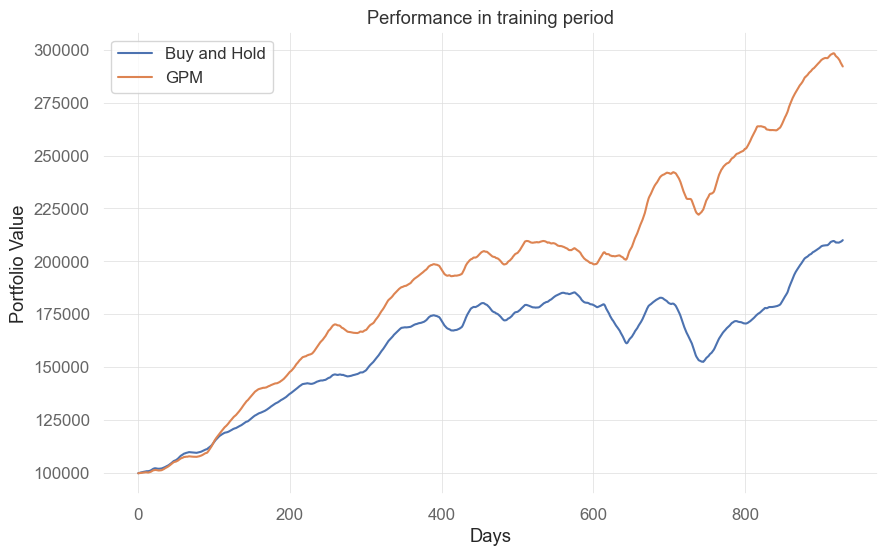

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(GPM_results["train"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

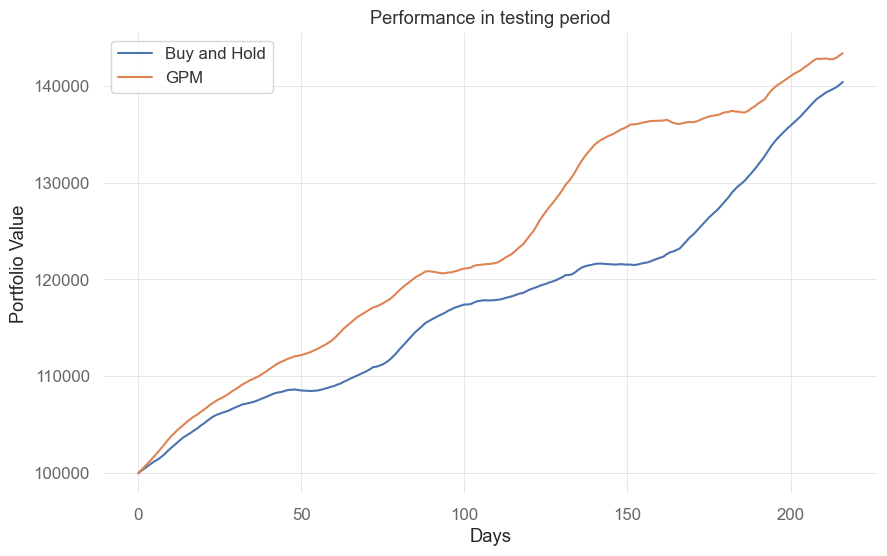

In [ ]:
plt.plot(UBAH_results["test"], label="Buy and Hold")
plt.plot(GPM_results["test"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period")
plt.legend()

plt.show()

With only two training episodes, we can see that GPM achieves better performance than buy and hold strategy, but according to the original article, that performance could be better. Hyperparameter tuning must be performed. Additionaly, we used softmax temperature equal to one, something that can be changed to achieve better performance as stated in the original article.